In [33]:
#auto reload 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from env.snake_env import SnakeEnv
import mediapy as media
import pygame
import numpy as np

In [35]:
import yaml 
config = yaml.load(open("bcirl-snake-config.yaml", "r"), Loader=yaml.FullLoader)
env_config = config["env"]["env_settings"]["params"]["config"]
env_config["render_mode"] = "human"
n_exp = env_config["num_exp"]

""

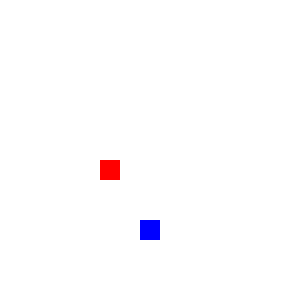

In [36]:
snakie = SnakeEnv(env_config)
snakie.render_mode = "rgb_array"
snakie.reset()
media.show_image(snakie.render())

In [37]:
import matplotlib.pyplot as plt

tensor([0.9333, 0.4667])


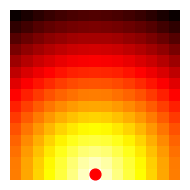

In [38]:
eval_env = SnakeEnv(env_config)
reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))
apple_pos = eval_env.reset()[0][:2]
print(apple_pos)
#test what you got so far by plotting a heat map of the reward using the snake only 
for x in range(eval_env.screen_width//eval_env.block_size):
    for y in range(eval_env.screen_height//eval_env.block_size ):
        x_grid = x * eval_env.block_size / eval_env.screen_width
        y_grid = y * eval_env.block_size / eval_env.screen_height
 
        reward_map[x,y] = 1.0-eval_env.normalized_distance((x_grid, y_grid), apple_pos)
fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the figsize as desired

# Plot the reward map without axis and numbers
image = ax.imshow(reward_map, cmap='hot', interpolation='nearest')
ax.axis('off')

# Plot the apple
ax.scatter(
    apple_pos[1] * eval_env.screen_height // eval_env.block_size,
    apple_pos[0] * eval_env.screen_width // eval_env.block_size,

    c='red',
    s=60
)
plt.tight_layout()
plt.show()

In [39]:
from collections import deque

def to_grid(snakie):
    #transform the observation into a grid 
    image = np.zeros((snakie.screen_height//snakie.block_size, snakie.screen_width//snakie.block_size),dtype=np.uint8)

    #red for the apple 
    image[snakie.apple.position[0]//snakie.block_size, snakie.apple.position[1]//snakie.block_size] = 3

    #green for the snake
    for pos in snakie.snake.body:
        image[pos[0]//snakie.block_size, pos[1]//snakie.block_size,] = 1
    #blue for the head
    image[snakie.snake.head[0]//snakie.block_size, snakie.snake.head[1]//snakie.block_size,] = 2
    return image 

def find_shortest_path(grid, player_location, apple_position):
    rows, cols = len(grid), len(grid[0])
    queue = deque()
    visited = set()
    queue.append(player_location)
    visited.add(player_location)
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    path = {}

    while queue:
        current_cell = queue.popleft()
        if current_cell == apple_position:
            break

        for direction in directions:
            next_row = current_cell[0] + direction[0] 
            next_col = current_cell[1] + direction[1]
            next_cell = (next_row, next_col)
            print(player_location,next_cell)
            if 0 <= next_row < rows and 0 <= next_col < cols and grid[next_row][next_col] != 1 and next_cell not in visited:
                queue.append(next_cell)
                visited.add(next_cell)
                path[next_cell] = current_cell
    print(path)
    if apple_position not in path:
        return None

    # Reconstruct the path
    current_cell = apple_position
    while current_cell != player_location:
        parent_cell = path[current_cell]
        if (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (1, 0):
            action = 0
        elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (-1, 0):
            action = 1
        elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (0, 1):
            action = 2
        else:
            action = 3
        return action

In [40]:
import heapq

def astar(start, goal, walls, grid_width, grid_height):
    """
    A* algorithm implementation to find the shortest path from start to goal
    on a grid with walls represented as 1s.
    """
    # Define the heuristic function as the Manhattan distance
    def heuristic(node):
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])
    
    # Initialize the open and closed sets
    open_set = [(0, start)]
    closed_set = set()
    
    # Initialize the g score for the start node
    g_score = {start: 0}
    
    # Initialize the parent dictionary to keep track of the path
    parent = {}
    
    while open_set:
        # Get the node with the lowest f score from the open set
        current = heapq.heappop(open_set)[1]
        
        # If we've reached the goal, reconstruct the path and return it
        if current == goal:
            path = []
            while current in parent:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path
        
        # Add the current node to the closed set
        closed_set.add(current)
        
        # Check the neighbors of the current node
        for neighbor in [(current[0]+1, current[1]), (current[0]-1, current[1]), (current[0], current[1]+1), (current[0], current[1]-1)]:
            #make sure you stay in the grid
            if neighbor[0] < 0 or neighbor[0] >= grid_width or neighbor[1] < 0 or neighbor[1] >= grid_height:
                continue
            # Skip neighbors that are walls or already in the closed set
            if neighbor in walls or neighbor in closed_set:
                continue
            
            # Calculate the tentative g score for the neighbor
            tentative_g_score = g_score[current] + 1
            
            # If the neighbor is not in the open set, add it and calculate its f score
            if neighbor not in [node[1] for node in open_set]:
                heapq.heappush(open_set, (tentative_g_score + heuristic(neighbor), neighbor))
            # If the neighbor is already in the open set, update its g score if the new score is lower
            elif tentative_g_score < g_score[neighbor]:
                if((g_score[neighbor] + heuristic(neighbor), neighbor) in open_set):
                        
                    open_set.remove((g_score[neighbor] + heuristic(neighbor), neighbor))
                    heapq.heappush(open_set, (tentative_g_score + heuristic(neighbor), neighbor))
            
            # Update the parent and g score dictionaries
            parent[neighbor] = current
            g_score[neighbor] = tentative_g_score
            
    # If we've exhausted all possible paths and haven't found the goal, return None
    return None


In [41]:
import heapq

# Define a class for representing a node in the grid
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.g = float('inf')  # Cost from start node
        self.h = 0  # Heuristic cost to goal node
        self.f = float('inf')  # Total cost (g + h)
        self.parent = None

    def __lt__(self, other):
        return self.f < other.f

# Calculate the Manhattan distance between two nodes
def manhattan_distance(node1, node2):
    return abs(node1.x - node2.x) + abs(node1.y - node2.y)

# A* algorithm implementation
def astar(start, goal, walls, grid_width, grid_height):
    # Create a 2D grid of nodes
    grid = [[Node(x, y) for y in range(grid_height)] for x in range(grid_width)]

    # Set the start node properties
    start_node = grid[start[0]][start[1]]
    start_node.g = 0
    start_node.h = manhattan_distance(start_node, grid[goal[0]][goal[1]])
    start_node.f = start_node.g + start_node.h

    # Set up the open and closed sets
    open_set = [start_node]
    closed_set = set()

    while open_set:
        # Get the node with the lowest f value from the open set
        current_node = heapq.heappop(open_set)

        # Check if the goal has been reached
        if current_node.x == goal[0] and current_node.y == goal[1]:
            path = []
            while current_node.parent:  # Exclude the starting node
                path.append((current_node.x, current_node.y))
                current_node = current_node.parent
            return path[::-1]  # Return reversed path

        # Add the current node to the closed set
        closed_set.add((current_node.x, current_node.y))

        # Generate the neighbors of the current node
        neighbors = []
        if current_node.x > 0:
            neighbors.append(grid[current_node.x - 1][current_node.y])
        if current_node.x < grid_width - 1:
            neighbors.append(grid[current_node.x + 1][current_node.y])
        if current_node.y > 0:
            neighbors.append(grid[current_node.x][current_node.y - 1])
        if current_node.y < grid_height - 1:
            neighbors.append(grid[current_node.x][current_node.y + 1])

        for neighbor in neighbors:
            # Check if the neighbor is a wall or already in the closed set
            if (neighbor.x, neighbor.y) in walls or (neighbor.x, neighbor.y) in closed_set:
                continue

            # Calculate the tentative g value
            tentative_g = current_node.g + 1

            # Check if the neighbor is already in the open set
            if neighbor not in open_set:
                heapq.heappush(open_set, neighbor)
            elif tentative_g >= neighbor.g:
                continue  # Not a better path

            # Update the neighbor's properties
            neighbor.parent = current_node
            neighbor.g = tentative_g
            neighbor.h = manhattan_distance(neighbor, grid[goal[0]][goal[1]])
            neighbor.f = neighbor.g + neighbor.h

    return []  # No path found
# Example usage:
start = (0, 0)
goal = (4, 4)
walls = [(1, 0), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3)]  # Coordinates of wall nodes
grid_width = 5
grid_height = 5
path = astar(start, goal, walls, grid_width, grid_height)
print(path)
#print the grid : 
grid = np.zeros((grid_width, grid_height),dtype=np.uint8)
for x in range(grid_width):
    for y in range(grid_height):
        if (x,y) in walls:
            grid[x,y] = 1
        if (x,y) in path:
            grid[x,y] = 2
        if (x,y) == start:
            grid[x,y] = 3
        if (x,y) == goal:
            grid[x,y] = 4
print(grid)

[(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (2, 4), (3, 4), (4, 4)]
[[3 2 2 2 0]
 [1 1 1 2 0]
 [0 0 1 2 2]
 [0 0 1 1 2]
 [0 0 0 0 4]]


In [42]:
def path_finder(start, goal, walls, grid_width, grid_height):
    # Define the possible movements from a cell (up, down, left, right, diagonal)
    movements = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Create a set to store visited cells
    visited = set()

    # Create a dictionary to store the parent cell for each visited cell
    parent = {}

    # Create a dictionary to store the cost of reaching each cell from the start
    g_score = {}

    # Create a dictionary to store the estimated total cost from the start to the goal through each cell
    f_score = {}

    # Initialize the g_score and f_score for the start cell
    g_score[start] = 0
    f_score[start] = heuristic(start, goal)

    # Create a priority queue (min-heap) to store the cells to be visited
    queue = [(f_score[start], start)]

    while queue:
        # Get the cell with the lowest f_score from the queue
        current_f, current = heapq.heappop(queue)

        # Check if the current cell is the goal
        if current == goal:
            return reconstruct_path(parent, current)

        # Mark the current cell as visited
        visited.add(current)

        # Explore the neighboring cells
        for dx, dy in movements:
            neighbor = current[0] + dx, current[1] + dy

            # Skip if the neighbor is outside the grid boundaries
            if not is_valid_cell(neighbor, grid_width, grid_height):
                continue

            # Skip if the neighbor is a wall
            if neighbor in walls:
                continue

            # Calculate the tentative g_score for the neighbor
            tentative_g = g_score[current] + distance(current, neighbor)

            # Check if the neighbor has been visited or has a better g_score
            if neighbor in visited and tentative_g >= g_score.get(neighbor, float('inf')):
                continue

            # Update the parent and g_score for the neighbor
            parent[neighbor] = current
            g_score[neighbor] = tentative_g

            # Calculate the f_score for the neighbor
            f_score[neighbor] = tentative_g + heuristic(neighbor, goal)

            # Add the neighbor to the queue
            heapq.heappush(queue, (f_score[neighbor], neighbor))

    # No path found
    return None

def is_valid_cell(cell, grid_width, grid_height):
    x, y = cell
    return 0 <= x < grid_width and 0 <= y < grid_height

def distance(cell1, cell2):
    x1, y1 = cell1
    x2, y2 = cell2
    return abs(x2 - x1) + abs(y2 - y1)

def heuristic(cell, goal):
    x1, y1 = cell
    x2, y2 = goal
    return abs(x2 - x1) + abs(y2 - y1)

def reconstruct_path(parent, current):
    path = [current]
    while current in parent:
        current = parent[current]
        path.append(current)
    return list(reversed(path))


In [43]:
start = (0, 0)
goal = (4, 4)
walls = {(1, 2), (2, 2), (3, 2)}
grid_width = 5
grid_height = 5

path = path_finder(start, goal, walls, grid_width, grid_height)

if path:
    print("Path found:")
    for cell in path:
        print(cell)
else:
    print("No path found.")


Path found:
(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)
(2, 1)
(3, 0)
(3, 1)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)


In [44]:
# Define the grid and the player and apple positions
grid = [[1, 1, 1, 1],
        [1, 0, 0, 1],
        [1, 1, 3, 1],
        [1, 1, 1, 1]]
player_pos = (1, 1)
apple_pos = (2, 2)

# Find the shortest path using the A* algorithm
walls = [(i, j) for i in range(len(grid)) for j in range(len(grid[0])) if grid[i][j] == 1]

astar(player_pos, apple_pos, walls , len(grid), len(grid[0]))

[(1, 2), (2, 2)]

In [45]:
def astar2(start, goal, walls, grid_width, grid_height):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    closest_distance = float('inf')
    closest_cell = None
    for direction in directions:
        next_cell = (start[0] + direction[0] , start[1] + direction[1])
        #check that next cell is in the grid and not in the walls
        if 0 <= next_cell[0] < grid_width and 0 <= next_cell[1] < grid_height and next_cell not in walls:
            distance_to_goal = abs(next_cell[0] - goal[0]) + abs(next_cell[1] - goal[1])
            if distance_to_goal < closest_distance:
                closest_distance = distance_to_goal
                closest_cell = next_cell
    
    return closest_cell

In [46]:

expert_exp = {"reward": [], "action": [], "observation": [], "terminal": [], "next_observation": [] , "info": []}
snakie = SnakeEnv({**env_config})
snakie.reset()
n_exp = 10
for experience in range(n_exp):
    #run forever and take actions from keyboard and collect data about the reward

    expert_exp["observation"].append(snakie.reset()[0])
    done = False
    action = 0 
    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                
        walls =[(x//snakie.block_size,y//snakie.block_size) for (x,y) in snakie.snake.body[:-1]]


        current_cell = (snakie.snake.head[0]//snakie.block_size,snakie.snake.head[1]//snakie.block_size)


        next_cell =  astar2(current_cell, (snakie.apple.position[0]//snakie.block_size,snakie.apple.position[1]//snakie.block_size), walls, snakie.screen_width//snakie.block_size, snakie.screen_height//snakie.block_size)
        
        if next_cell is not None:
            diff = (next_cell[0] - current_cell[0], next_cell[1] - current_cell[1])

            if diff == (1, 0):
                action = 3 
            if diff == (-1, 0):
                action = 2
            if diff == (0, 1):
                action = 1
            if diff == (0, -1):
                action = 0

        probs = [-1.0]*4
        probs[action] = 0.0

        obs,reward,done,_,info= snakie.step(probs)

        expert_exp["reward"].append(reward.tolist())
        expert_exp["action"].append(probs)
        expert_exp["observation"].append(obs)
        expert_exp["terminal"].append(done)
        expert_exp["next_observation"].append(obs) 

        if done: 
            expert_exp["info"].append({"dist_to_goal":0.0, "episode":{} , "final_obs": [snakie.apple.position[0] / snakie.screen_height , snakie.apple.position[1] / snakie.screen_width]* 2})
        else: 
            expert_exp["info"].append({"dist_to_goal": snakie.normalized_distance(snakie.snake.head, snakie.apple.position) })
        # print(expert_exp["action"][-1], expert_exp["reward"][-1], expert_exp["terminal"][-1])
        
        snakie.render("human")


        pygame.time.wait(10)
 

    expert_exp["observation"] = expert_exp["observation"][:-1]
# pygame.quit()

In [47]:
action

2

In [48]:
# n_exp = 4
# expert_exp = {"reward": [], "action": [], "observation": [], "terminal": [], "next_observation": []}
# snakie = SnakeEnv({**env_config})
# pygame.time.wait(1000)
# for experience in range(n_exp):
#     #run forever and take actions from keyboard and collect data about the reward

#     expert_exp["observation"].append(snakie.reset()[0])
#     done = False
#     action = 0 
#     while not done:
#         for event in pygame.event.get():
#             if event.type == pygame.QUIT:
#                 pygame.quit()
#             if event.type == pygame.KEYDOWN:
#                 if event.key == pygame.K_LEFT:
#                     action = 2
#                 elif event.key == pygame.K_RIGHT:
#                     action = 3
#                 elif event.key == pygame.K_UP:
#                     action = 0
#                 elif event.key == pygame.K_DOWN:
#                     action = 1

#         probs = [0,0,0,0]
#         probs[action] = 1
#         obs,reward,done,info= snakie.step(probs)
   
#         expert_exp["reward"].append(reward)
#         expert_exp["action"].append(probs)
#         expert_exp["observation"].append(obs)
#         expert_exp["terminal"].append(done)
#         expert_exp["next_observation"].append(obs)
#         # print(expert_exp["action"][-1], expert_exp["reward"][-1], expert_exp["terminal"][-1])
        
#         snakie.render("human")
#         pygame.time.wait(50)
#     expert_exp["observation"] = expert_exp["observation"][:-1]
# pygame.quit()

In [49]:
# #plot the reward collected by the expert as a heat map 

# heat_map = np.zeros((snakie.screen_height//snakie.block_size, snakie.screen_width//snakie.block_size))
# counts = np.zeros((snakie.screen_height//snakie.block_size, snakie.screen_width//snakie.block_size))
# for i in range(len(expert_exp["observation"])):
#     [x,y] = expert_exp["observation"][i][2:4]
#     (x,y) = int(x*snakie.screen_width / snakie.block_size),int(y * snakie.screen_height / snakie.block_size)
#     heat_map[x,y] += expert_exp["reward"][2][i]
#     counts[x,y] += 1

# heat_map = heat_map/counts
# plt.imshow(heat_map, cmap='hot', interpolation='nearest')
# plt.show()


In [50]:
print(len(expert_exp["next_observation"]))
print(len(expert_exp["observation"]))

95
95


In [51]:
import torch

In [52]:
observations =[obs[0].tolist() if isinstance(obs, tuple) else obs.tolist() for obs in expert_exp["observation"]]

In [53]:
new_observation = [obs[0].tolist() if isinstance(obs, tuple) else obs.tolist() for obs in expert_exp["next_observation"]]

In [54]:
actions = expert_exp["action"]

In [55]:
dones = expert_exp["terminal"]

In [56]:
rewards = expert_exp["reward"]

In [57]:
infos = expert_exp["info"]

In [58]:
infos

[{'dist_to_goal': 0.2538591035287969},
 {'dist_to_goal': 0.2403700850309326},
 {'dist_to_goal': 0.2357022603955158},
 {'dist_to_goal': 0.18856180831641267},
 {'dist_to_goal': 0.1414213562373095},
 {'dist_to_goal': 0.09428090415820634},
 {'dist_to_goal': 0.04714045207910317},
 {'dist_to_goal': 0.0,
  'episode': {},
  'final_obs': [0.7333333333333333,
   0.06666666666666667,
   0.7333333333333333,
   0.06666666666666667]},
 {'dist_to_goal': 0.42426406871192845},
 {'dist_to_goal': 0.37712361663282534},
 {'dist_to_goal': 0.3299831645537222},
 {'dist_to_goal': 0.282842712474619},
 {'dist_to_goal': 0.2357022603955158},
 {'dist_to_goal': 0.18856180831641267},
 {'dist_to_goal': 0.1414213562373095},
 {'dist_to_goal': 0.09428090415820634},
 {'dist_to_goal': 0.04714045207910317},
 {'dist_to_goal': 0.0,
  'episode': {},
  'final_obs': [0.06666666666666667,
   0.13333333333333333,
   0.06666666666666667,
   0.13333333333333333]},
 {'dist_to_goal': 0.2357022603955158},
 {'dist_to_goal': 0.1885618083

In [59]:
tobejsoned = {"observations": observations, "actions": actions, "terminals": dones, "next_observations": new_observation , "rewards": rewards, "infos": infos}

In [60]:
import json
with open("expert_data.json", "w") as f:
    json.dump(tobejsoned, f)

In [61]:
tobejsoned["terminals"].count(True)

10

In [62]:
f = open("expert_data.json")
loaded = json.load(f)


In [63]:
dones

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]